## 📘 Guía de ejercicios

Podés abrir la [Guía de ejercicios en Google Colab](https://colab.research.google.com/github/mercedesgarnham/Curso_quimioinformatica_IA/blob/main/notebooks/guia_de_ejercicios.ipynb) para interactuar con la notebook directamente en tu navegador.


## 📌 Contenidos mínimos recomendados

Antes del curso, se recomienda revisar los contenidos de introducción a Python para poder seguir los ejercicios:  
[Introducción a Python – RSG Argentina](https://rsg-argentina.netlify.app/workshops/introduccion_a_python/)


# Introducción a Machine Learning (ML)

## ¿Qué es Machine Learning?

Machine Learning (aprendizaje automático) es una rama de la inteligencia artificial que permite a las computadoras aprender patrones y tomar decisiones a partir de datos, sin ser explícitamente programadas para cada tarea.

En lugar de seguir reglas fijas, un modelo de ML utiliza datos históricos para “aprender” y luego hacer predicciones o clasificaciones sobre datos nuevos.

## Tipos principales de Machine Learning

- **Aprendizaje Supervisado:**  
  El modelo aprende a partir de un conjunto de datos etiquetados, donde cada entrada tiene una salida conocida.  
  Ejemplos: clasificación (activo vs inactivo), regresión (predecir una propiedad continua).

- **Aprendizaje No Supervisado:**  
  El modelo encuentra patrones o agrupamientos en datos sin etiquetas.  
  Ejemplo: clustering para identificar grupos de moléculas similares.

- **Aprendizaje por Refuerzo:**  
  El modelo aprende a tomar decisiones mediante prueba y error, recibiendo recompensas o penalizaciones.

## Componentes clave en ML

- **Datos:** el combustible para el aprendizaje.  
- **Características (features):** representaciones numéricas de los datos que el modelo usa para aprender.  
- **Modelo:** algoritmo matemático que encuentra patrones en los datos.  
- **Función objetivo:** métrica que el modelo optimiza durante el entrenamiento.  
- **Entrenamiento:** proceso de ajustar el modelo a los datos para minimizar errores.  
- **Evaluación:** medir qué tan bien el modelo funciona con datos no vistos.

## Aplicación en Quimioinformática

En quimioinformática, ML se usa para predecir propiedades moleculares, actividad biológica, toxicidad, entre otros, a partir de la estructura química y datos experimentales.



# Datos y Análisis de Datos Químicos

## Introducción: ¿Por qué es importante el tipo de dato?

En quimioinformática y modelado molecular, la calidad y tipo de datos que utilicemos es fundamental, ya que influyen directamente en el desempeño y confiabilidad de nuestros modelos de inteligencia artificial.

No todos los datos son iguales: elegir adecuadamente el tipo de datos y su fuente es clave para obtener resultados robustos y útiles.

## Fuentes de datos

Podemos obtener datos químicos y biológicos de diferentes orígenes:

- **Datos propios:**  
  Resultados experimentales generados en nuestro laboratorio o proyecto. Estos datos suelen ser muy específicos y controlados, pero pueden ser limitados en cantidad.

- **Datos de publicaciones científicas:**  
  Información reportada en artículos y trabajos de investigación. Es importante validar la calidad y contexto de estos datos antes de usarlos.

- **Bases de datos públicas:**  
  Repositorios como ChEMBL, PubChem que almacenan miles o millones de compuestos con sus propiedades y resultados de bioensayos.

## Tipos de datos y su impacto

Los datos químicos y biológicos pueden venir en diferentes formatos y contextos, por ejemplo:

- **Estructuras moleculares:**  
  Generalmente representadas como SMILES o InChI, son la base para cualquier análisis y modelado.

- **Bioactividad:**  
  Indican si una molécula es activa o inactiva frente a un target o ensayos específicos. Esta información puede variar según el tipo de bioensayo utilizado.

- **Tipos de bioensayos:**  
  Cada tipo de ensayo mide diferentes aspectos biológicos o farmacológicos, como:

  - Ensayos de inhibición enzimática (p.ej. IC50, Ki)  
  - Ensayos celulares funcionales  
  - Ensayos fenotípicos  
  - Ensayos toxicológicos

La selección del tipo de bioensayo afecta la definición de “actividad” y por lo tanto el etiquetado de los datos para el entrenamiento del modelo.

## Importancia de la correcta selección y curación de datos

- **Consistencia:**  
  Es clave que los datos provengan de ensayos comparables para evitar introducir ruido o sesgo.

- **Cantidad vs calidad:**  
  A veces hay que balancear tener muchos datos con tener datos confiables y bien caracterizados.

- **Preprocesamiento y validación:**  
  Limpieza, filtrado y normalización son pasos imprescindibles para preparar los datos antes de modelar.


# Ejemplos de Uso de Machine Learning en Quimioinformática con Referencias

Machine Learning tiene múltiples aplicaciones en quimioinformática. 

## Material de consulta: 

- [Practical Cheminformatics](https://patwalters.github.io/)
- [A Deep Learning Approach to Antibiotic Discovery](https://www.sciencedirect.com/science/article/pii/S0092867420301021)
- [AI in Drug Discovery](https://link.springer.com/book/10.1007/978-3-031-72381-0)


Empecemos a trabajar!!

In [38]:
!pip install pandas scikit-learn rdkit matplotlib seaborn xgboost

In [39]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdFingerprintGenerator, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


In [40]:
url = "https://raw.githubusercontent.com/mercedesgarnham/Curso_quimioinformatica_IA/refs/heads/main/data/AID_1885.csv"
df = pd.read_csv(url, sep =",")

df = df[['PUBCHEM_ACTIVITY_OUTCOME','PUBCHEM_EXT_DATASOURCE_SMILES']]
df = df.dropna().reset_index(drop=True)
df.head()

C:\Users\Merce\AppData\Local\Temp\ipykernel_5560\4099903771.py:2: DtypeWarning: Columns (0,8,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep =",")


,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_EXT_DATASOURCE_SMILES
0,Inactive,C1CCCN(CC1)C(=O)CS(=O)(=O)C2=CC3=CC=CC=C3C=C2
1,Inactive,COC1=CC=CC=C1NC(=O)CC2C(=O)NC3=CC=CC=C3N2C(=O)...
2,Inactive,COC1=C(C=CC(=C1)CNCCNC(=O)C2=NON=C2N)OCC3=CC=C...
3,Inactive,CC(C1=CC=CC=C1)NC2=NC(=NC3=CC=CC=C32)N4CCNCC4
4,Inactive,CC1=C(C(=CC=C1)C)NC(=O)CSC2=NC(=O)C(C(=O)N2)NC...


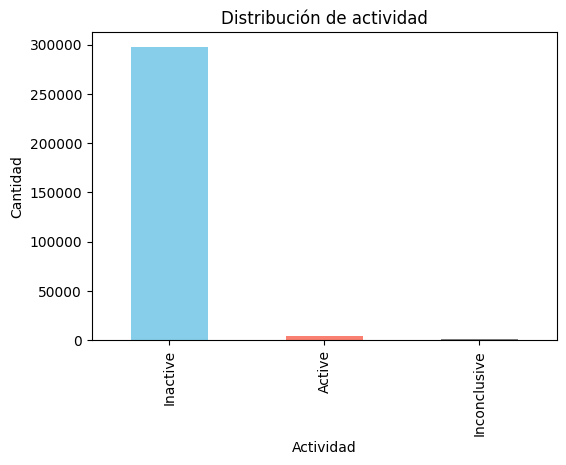

In [41]:
# Visualización rápida
plt.figure(figsize=(6,4))
df['PUBCHEM_ACTIVITY_OUTCOME'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', "grey"])
plt.title('Distribución de actividad')
plt.xlabel('Actividad')
plt.ylabel('Cantidad')
plt.show()

In [42]:
# Filtrar solo Active e Inactive
df_filtered = df[df['PUBCHEM_ACTIVITY_OUTCOME'].isin(['Active', 'Inactive'])].copy()
df_filtered.reset_index(drop=True, inplace=True)

In [43]:
# Procesar SMILES y crear objetos Mol (RDKit)
def mol_from_smiles(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None

df_filtered['mol'] = df_filtered['PUBCHEM_EXT_DATASOURCE_SMILES'].apply(mol_from_smiles)
df_filtered = df_filtered[df_filtered['mol'].notnull()].copy()
df_filtered.reset_index(drop=True, inplace=True)

[21:16:37] WARNING: not removing hydrogen atom without neighbors
[21:16:38] WARNING: not removing hydrogen atom without neighbors


# Distribución de datos

## Uso de dataset completo vs. dataset balanceado en modelos de Machine Learning

Cuando entrenamos un modelo de Machine Learning sobre un dataset **desbalanceado**, como suele ocurrir con compuestos activos e inactivos, el modelo puede verse sesgado hacia la **clase mayoritaria**. Esto significa que:

- Puede predecir correctamente la clase mayoritaria la mayor parte del tiempo.
- Puede ignorar o predecir mal la clase minoritaria (por ejemplo, los compuestos activos si son pocos).
- Las métricas tradicionales como **accuracy** pueden ser engañosas, porque un modelo que siempre predice la clase mayoritaria puede tener alta precisión sin realmente aprender nada útil.

Al usar un **dataset balanceado**, mediante muestreo aleatorio o técnicas como SMOTE, conseguimos:

- Que el modelo tenga **igual exposición a ambas clases**, aprendiendo patrones de manera más justa.
- Mejores métricas de evaluación para ambas clases, como **recall, precision y F1-score**.
- Menor riesgo de sobreajuste hacia la clase mayoritaria.

⚠️ Nota: Balancear puede implicar **perder información de la clase mayoritaria** si se hace muestreo aleatorio, pero es un compromiso necesario cuando el desbalance es fuerte.


## Impacto del desbalance de datos en Drug Discovery

En Drug Discovery, los datasets de bioactividad suelen estar **muy desbalanceados**: la mayoría de los compuestos son **inactivos** frente a un target, y solo unos pocos son **activos**. Esto tiene varias implicancias para Machine Learning:

### Problemas al usar todos los datos
- El modelo tiende a predecir la clase mayoritaria (**inactivos**) casi siempre.  
- Métricas como **accuracy** pueden ser engañosas, mostrando buen desempeño aunque falle en detectar activos.  
- Los **falsos negativos** (no detectar un compuesto activo) son críticos, porque se pierden candidatos potenciales de fármaco.

### Beneficios de usar un dataset balanceado
- Igual exposición a ambas clases, ayudando al modelo a **aprender patrones de activos**.  
- Mejora de métricas relevantes como **recall, precision y F1-score** para la clase minoritaria.  
- Menor sesgo hacia la clase mayoritaria, permitiendo identificar compuestos activos prometedores.

### Estrategias comunes
- **Muestreo aleatorio** de inactivos o **sobremuestreo** de activos (SMOTE).  
- **Ponderar la clase minoritaria** en la función de pérdida del modelo.  
- Evaluar con métricas **sensible a desbalance** (recall, F1-score, ROC-AUC) en lugar de solo accuracy.

> ⚠️ En resumen: balancear o ponderar datos es clave en drug discovery para que los modelos ML detecten compuestos activos, que son los más valiosos.


In [44]:
# Flag para decidir si usar dataset balanceado o completo
usar_balanceado = True  # Cambiar a False para usar todos los datos (sampleado)

# Número de activos para el dataset balanceado
actives = df_filtered[df_filtered['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active']
n_actives = len(actives)

if usar_balanceado:
    # Balancear dataset con muestreo aleatorio de inactivos para igualar cantidad de activos
    inactives = df_filtered[df_filtered['PUBCHEM_ACTIVITY_OUTCOME'] == 'Inactive']
    inactives_sampled = inactives.sample(n=n_actives, random_state=42)  # Semilla para reproducibilidad

    df_final = pd.concat([actives, inactives_sampled]).reset_index(drop=True)

    print(f"Cantidad de activos: {len(actives)}")
    print(f"Cantidad de inactivos muestreados: {len(inactives_sampled)}")
    print(f"Tamaño total dataset balanceado: {len(df_final)}")
else:
    # Usar todos los datos pero tomar un sample del mismo tamaño que el balanceado
    df_sampled = df_filtered.sample(n=n_actives*2, random_state=42)  # mismo tamaño que balanceado
    df_final = df_sampled.reset_index(drop=True)

    print(f"Tamaño total dataset sampleado: {len(df_final)}")
    print(df_final['PUBCHEM_ACTIVITY_OUTCOME'].value_counts())



Cantidad de activos: 4396
Cantidad de inactivos muestreados: 4396
Tamaño total dataset balanceado: 8792


In [45]:
# Calcular propiedades fisicoquímicas básicas
def calc_properties(mol):
    return {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol)
    }

props = df_final['mol'].apply(calc_properties)
props_df = pd.DataFrame(list(props))
df_final = pd.concat([df_final, props_df], axis=1)

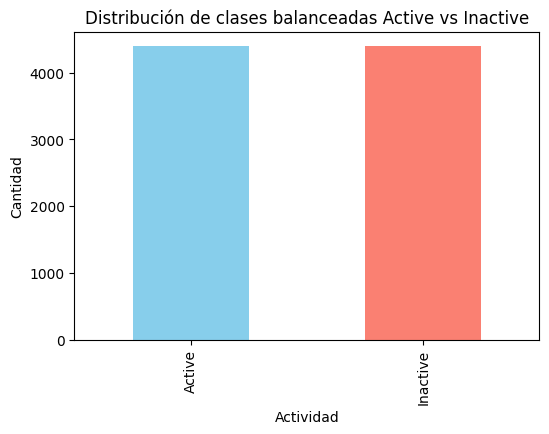

In [46]:
# Visualizar distribución de clases balanceadas
plt.figure(figsize=(6,4))
df_final['PUBCHEM_ACTIVITY_OUTCOME'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de clases balanceadas Active vs Inactive')
plt.xlabel('Actividad')
plt.ylabel('Cantidad')
plt.show()


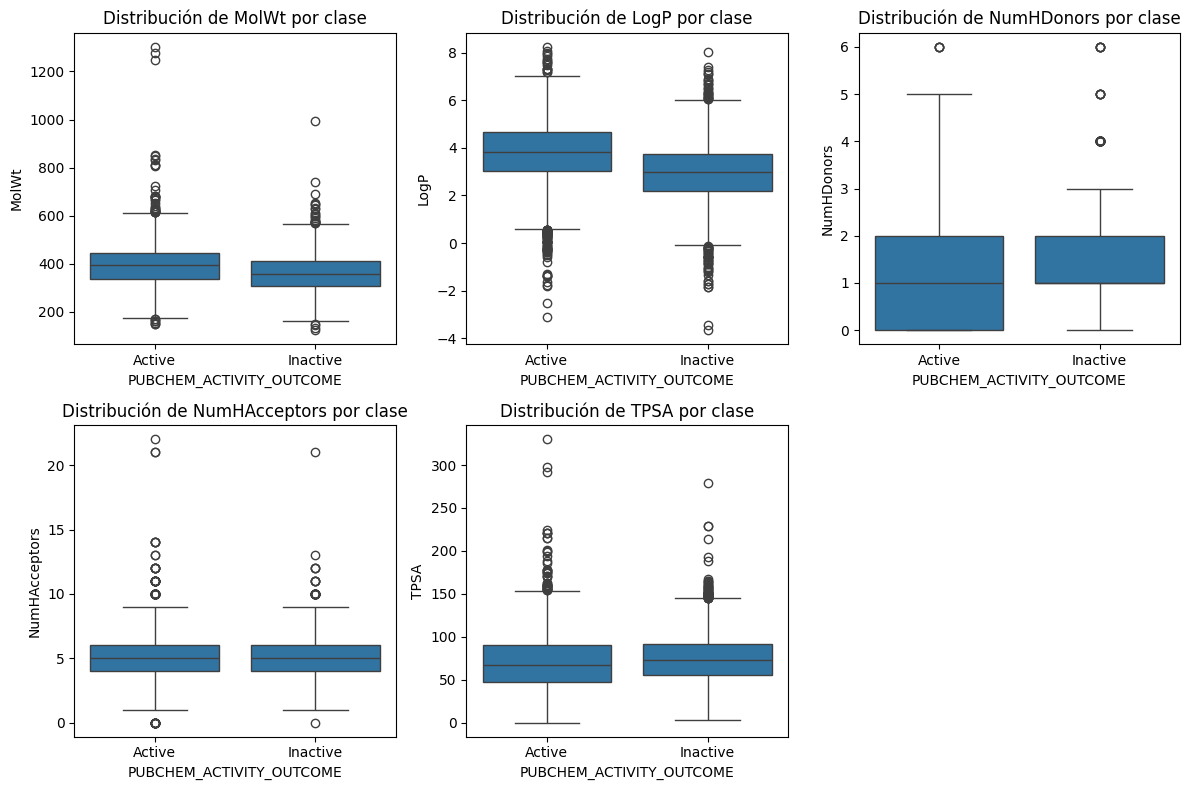

In [47]:
# Visualización de propiedades por clase balanceadas
plt.figure(figsize=(12,8))
for i, prop in enumerate(['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']):
    plt.subplot(2,3,i+1)
    sns.boxplot(x='PUBCHEM_ACTIVITY_OUTCOME', y=prop, data=df_final)
    plt.title(f'Distribución de {prop} por clase')
plt.tight_layout()
plt.show()

# Representación y Featurización de Moléculas

## ¿Por qué es importante la representación de las moléculas?

Una vez que hemos obtenido y curado nuestros datos químicos y bioactivos, el siguiente paso crítico es cómo representamos esas moléculas para que los algoritmos de Machine Learning puedan entenderlas y trabajar con ellas.

La representación o **featurización** convierte la estructura química en vectores numéricos o características que describen aspectos relevantes de las moléculas.

## Tipos comunes de featurización

- **Fingerprints (huellas moleculares):**  
  Representaciones binarias o numéricas que codifican la presencia o ausencia de subestructuras químicas, patrones o fragmentos.  
  Ejemplos:  
  - *Morgan fingerprints* (circular)  
  - *MACCS keys*  
  - *Topological fingerprints*

- **Descriptores fisicoquímicos:**  
  Valores numéricos que representan propiedades moleculares calculadas o experimentales, como:  
  - Peso molecular  
  - LogP (lipofilicidad)  
  - Número de átomos de hidrógeno donadores y aceptores  
  - Número de rotaciones libres  
  - Polaridad, etc.

- **Representaciones basadas en gráficos:**  
  Modelos más complejos que consideran la estructura molecular como un grafo (nodos y enlaces) para modelos de Deep Learning.

## ¿Cómo elegir la mejor forma de featurizar?

- Depende del **tipo de modelo** que usarás: algunos modelos funcionan mejor con fingerprints, otros con descriptores, y los modelos de deep learning pueden usar representaciones más complejas.  
- Depende de la **cantidad y calidad de datos**: con pocos datos, las representaciones simples pueden ser más robustas.  
- Depende del **problema y la tarea específica**: por ejemplo, predicción de actividad biológica, propiedades fisicoquímicas, etc.  
- La **interpretabilidad** también es clave: algunos descriptores permiten entender mejor qué propiedades influyen en la predicción.


## Fingerprints utilizados en el análisis de moléculas

En nuestro trabajo usamos los siguientes fingerprints, que son representaciones binarias o vectoriales de las moléculas:

| Fingerprint | Tipo de información | Qué captura | Uso típico |
|------------|-------------------|------------|------------|
| **fp_morgan_array** | Circular / ECFP | Entorno local de átomos (subestructuras) hasta un radio determinado | QSAR, similitud molecular, búsqueda de compuestos activos |
| **fp_rdkit_array** | Topológico lineal | Caminos lineales de átomos dentro de la molécula | Comparación rápida de moléculas, clustering |
| **fp_maccs_array** | MACCS keys (166 bits) | Presencia o ausencia de subestructuras predefinidas | Filtros químicos, búsqueda rápida, comparación básica |
| **fp_topological_torsion_array** | Torsiones topológicas | Secuencias de 4 átomos conectados (torsiones) | QSAR, relación con actividad biológica |
| **fp_atom_pair_array** | Pares de átomos + distancia topológica | Relación global entre pares de átomos y distancia entre ellos | Similitud global, moléculas grandes, detección de patrones espaciales |

> ⚡ **Nota:** Cada fingerprint captura diferentes aspectos de la química de las moléculas. La elección del fingerprint puede impactar el rendimiento del modelo de Machine Learning y su capacidad de detectar compuestos activos.


In [48]:
# Función para convertir fingerprint a numpy array
def fp_to_array(fp):
    arr = np.zeros((fp.GetNumBits(),), dtype=int)
    Chem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Morgan Fingerprints (radius=2, 1024 bits)
df_final['fp_morgan'] = df_final['mol'].apply(
    lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=1024)
)
df_final['fp_morgan_array'] = df_final['fp_morgan'].apply(fp_to_array)

# RDKit Fingerprints (default params)
df_final['fp_rdkit'] = df_final['mol'].apply(lambda m: Chem.RDKFingerprint(m))
df_final['fp_rdkit_array'] = df_final['fp_rdkit'].apply(fp_to_array)

# MACCS Keys (166 bits)
df_final['fp_maccs'] = df_final['mol'].apply(lambda m: MACCSkeys.GenMACCSKeys(m))
df_final['fp_maccs_array'] = df_final['fp_maccs'].apply(fp_to_array)

# Topological Torsion Fingerprints
topo_generator = rdFingerprintGenerator.GetTopologicalTorsionGenerator()
df_final['fp_topological_torsion'] = df_final['mol'].apply(lambda m: topo_generator.GetFingerprint(m))
df_final['fp_topological_torsion_array'] = df_final['fp_topological_torsion'].apply(fp_to_array)

# Atom Pair Fingerprints
atompair_generator = rdFingerprintGenerator.GetAtomPairGenerator()
df_final['fp_atom_pair'] = df_final['mol'].apply(lambda m: atompair_generator.GetFingerprint(m))
df_final['fp_atom_pair_array'] = df_final['fp_atom_pair'].apply(fp_to_array)


[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerator
[21:18:02] DEPRECATION WARNING: please use MorganGenerat

## Conceptos clave de Machine Learning

Machine Learning (ML) es un conjunto de técnicas que permite a las computadoras **aprender patrones a partir de datos** y hacer predicciones o clasificaciones sobre datos nuevos.  

### Elementos fundamentales

1. **Datos y features**  
   - Los modelos aprenden a partir de un conjunto de datos representados mediante **features** (variables predictoras).  
   - La calidad, relevancia y cantidad de features son cruciales para el rendimiento del modelo.  

2. **Etiquetas / targets**  
   - En problemas de clasificación, cada ejemplo tiene una **clase o categoría**.  
   - En problemas de regresión, cada ejemplo tiene un **valor numérico continuo** que el modelo intenta predecir.  

3. **Entrenamiento y evaluación**  
   - Los datos se dividen en **conjunto de entrenamiento** y **conjunto de prueba**.  
   - El entrenamiento consiste en ajustar los parámetros del modelo para **minimizar el error** sobre los datos conocidos.  
   - La evaluación se hace sobre datos no vistos para medir **generalización**, usando métricas como accuracy, precision, recall, f1-score, AUC, etc.

4. **Hiperparámetros**  
   - Son parámetros que **no se aprenden del entrenamiento**, sino que se fijan antes o se optimizan mediante validación cruzada.  
   - Ejemplos: número de árboles en Random Forest, `C` y `gamma` en SVM, `learning_rate` y `max_depth` en XGBoost.  

5. **Balanceo de clases**  
   - En datasets desbalanceados, donde algunas clases tienen muchos más ejemplos que otras, es recomendable usar técnicas como **submuestreo, sobremuestreo o ponderación de clases** para mejorar el rendimiento y la interpretabilidad.

6. **Selección de modelo**  
   - La elección del modelo depende del tipo de problema, tamaño del dataset, número de features, linealidad de las relaciones y la necesidad de interpretabilidad.  
   - Es recomendable **comparar varios modelos** y sus métricas de rendimiento para decidir cuál es el más adecuado.

> 🔹 Nota: En quimioinformática y drug discovery, la selección de fingerprints, el balance de datos y la interpretación de la importancia de features son **cruciales** para obtener resultados confiables y útiles.


# Elección del Modelo de Inteligencia Artificial

## ¿Por qué es importante elegir el modelo correcto?

La selección del modelo de Machine Learning o Deep Learning adecuado es clave para obtener predicciones precisas y confiables en tareas de quimioinformática. Diferentes modelos tienen ventajas y limitaciones según el tipo de datos, tamaño del dataset y complejidad del problema.

## Factores a considerar para elegir el modelo

- **Cantidad de datos disponibles:**  
  - Con grandes volúmenes de datos, los modelos de Deep Learning (como redes neuronales convolucionales o grafos neuronales) pueden capturar patrones complejos.  
  - Con pocos datos, modelos tradicionales como Random Forest, Support Vector Machines o regresión logística suelen ser más robustos y menos propensos al sobreajuste.

- **Tipo y complejidad de las características:**  
  - Para descriptores simples o fingerprints, modelos clásicos funcionan bien.  
  - Para representaciones basadas en grafos o secuencias, modelos basados en Deep Learning pueden ser más adecuados.

- **Interpretabilidad:**  
  - Modelos como Random Forest o regresiones permiten interpretar qué variables influyen en la predicción.  
  - Redes neuronales profundas suelen ser “cajas negras” y requieren técnicas adicionales para interpretarlas.

- **Tiempo y recursos computacionales:**  
  - Modelos simples entrenan y predicen rápidamente.  
  - Modelos complejos necesitan más poder de cómputo y tiempo de entrenamiento.

## Ejemplos comunes de modelos para quimioinformática

- **Random Forest:** Popular para clasificación y regresión, fácil de usar y robusto.  
- **Support Vector Machines (SVM):** Bueno para datasets medianos con alta dimensionalidad.  
- **Redes Neuronales Artificiales (ANN):** Flexibles, usadas con fingerprints o descriptores.  
- **Redes Neuronales Convolucionales (CNN):** Para datos con estructura espacial, como imágenes o secuencias.  
- **Modelos basados en Grafos:** Para representar directamente la estructura molecular.



## Métricas de evaluación en clasificación

Cuando trabajamos con modelos de clasificación, es importante evaluar su rendimiento usando métricas que reflejen **exactitud, balance y capacidad de predicción**.  

| Métrica | Qué mide | Fórmula básica | Interpretación |
|---------|----------|----------------|----------------|
| **Accuracy** | Porcentaje de predicciones correctas | (TP + TN) / (TP + TN + FP + FN) | Ideal si las clases están balanceadas; puede ser engañosa en datasets desbalanceados. |
| **Precision (o Positive Predictive Value)** | Qué proporción de predicciones positivas son correctas | TP / (TP + FP) | Alta precision indica pocas falsas alarmas. |
| **Recall (o Sensitivity / True Positive Rate)** | Qué proporción de positivos reales fueron correctamente identificados | TP / (TP + FN) | Alto recall indica que el modelo detecta la mayoría de positivos. |
| **F1-score** | Media armónica de precision y recall | 2 * (Precision * Recall) / (Precision + Recall) | Útil cuando necesitamos balancear precision y recall; importante en datasets desbalanceados. |
| **Specificity (True Negative Rate)** | Qué proporción de negativos reales fueron correctamente identificados | TN / (TN + FP) | Complemento del recall para la clase negativa. |
| **AUC-ROC** | Área bajo la curva ROC (recall vs. false positive rate) | Calculada a partir de probabilidades | Indica la capacidad de separar clases; 1 = perfecto, 0.5 = aleatorio. |
| **Confusion Matrix** | Matriz que muestra TP, TN, FP y FN | - | Permite ver errores por clase y ayuda a interpretar precision y recall. |

## Curva ROC (Receiver Operating Characteristic)

La **curva ROC** es una herramienta para evaluar el rendimiento de un modelo de clasificación, especialmente cuando se predicen probabilidades en lugar de clases directas.

### Concepto
- La curva muestra **la relación entre el True Positive Rate (Recall)** y **el False Positive Rate (1 - Specificity)** para distintos **umbrales de decisión**.
- Cada punto de la curva corresponde a un umbral diferente, es decir, a un valor de probabilidad a partir del cual clasificamos un ejemplo como positivo.

### Ejes de la curva
- **Eje X (FPR)**: False Positive Rate = FP / (FP + TN)  
- **Eje Y (TPR)**: True Positive Rate (Recall) = TP / (TP + FN)

### Área bajo la curva (AUC)
- El área bajo la curva (AUC) resume el desempeño del modelo en un solo número.  
  - AUC = 1 → modelo perfecto, separa todas las clases sin errores.  
  - AUC = 0.5 → modelo aleatorio, sin poder de discriminación.  
- Cuanto más se acerque la curva a la esquina superior izquierda, mejor es el modelo.

### Interpretación práctica
- Permite **comparar modelos independientemente del umbral elegido**.  
- Muy útil en **datasets desbalanceados**, como ocurre en drug discovery, donde los positivos son raros y elegir el umbral adecuado es crítico.



In [49]:
# Función para plotear matriz de confusión y ROC para un modelo dado
def plot_model_performance(model, X_test, y_test, model_name):
    # Matriz de confusión
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # Curva ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve - {model_name}")
    plt.show()

In [50]:
# Convertir actividad a 0/1
df_final['activity'] = df_final['PUBCHEM_ACTIVITY_OUTCOME'].str.lower().map({'active': 1, 'inactive': 0})

# Lista de fingerprints disponibles
fps_disponibles = ['fp_morgan_array', 'fp_rdkit_array', 'fp_maccs_array','fp_topological_torsion_array', 'fp_atom_pair_array']

# Elegir fingerprint
fp_elegido = fps_disponibles[0]  # Cambiar el índice o nombre según la elección

# Verificar si el fingerprint elegido está en la lista
if fp_elegido in fps_disponibles:
    X = np.stack(df_final[fp_elegido].values)
    y = df_final['activity'].values  

    # Dividir en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Usando fingerprint: {fp_elegido}")
    print(f"Forma de X: {X.shape}, forma de y: {y.shape}")

else:
    print(f"Error: el fingerprint elegido '{fp_elegido}' no está en la lista. Elegir uno de: {fps_disponibles}")


Usando fingerprint: fp_morgan_array
Forma de X: (8792, 1024), forma de y: (8792,)


### Random Forest: funcionamiento y características

**Random Forest** es un algoritmo de ensamble basado en árboles de decisión:

1. **Bosque de árboles**  
   - Construye múltiples árboles de decisión sobre **submuestras aleatorias de los datos**.  
   - Cada árbol se entrena usando un **subconjunto aleatorio de features**, lo que reduce el sobreajuste y aumenta la generalización.

2. **Predicción y votación**  
   - Cada árbol predice de manera independiente.  
   - La predicción final se obtiene mediante **votación mayoritaria** (clasificación) o promedio (regresión).

3. **Importancia de features**  
   - Random Forest permite evaluar cuánto contribuye cada feature a la predicción final, útil para interpretar modelos de QSAR o química computacional.

4. **Hiperparámetros principales**  
   - `n_estimators`: número de árboles en el bosque.  
   - `max_depth`: profundidad máxima de cada árbol.  
   - `min_samples_split`: mínimo de muestras requeridas para dividir un nodo.  
   - `min_samples_leaf`: mínimo de muestras que debe tener una hoja.  
   - `max_features`: número de features consideradas para la mejor división en cada nodo.  
   - `bootstrap`: si se utilizan muestras con reemplazo para construir cada árbol.


              precision    recall  f1-score   support

           0       0.77      0.79      0.78       881
           1       0.79      0.77      0.78       878

    accuracy                           0.78      1759
   macro avg       0.78      0.78      0.78      1759
weighted avg       0.78      0.78      0.78      1759



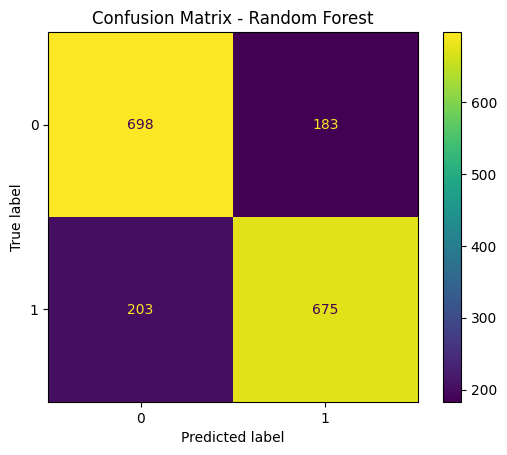

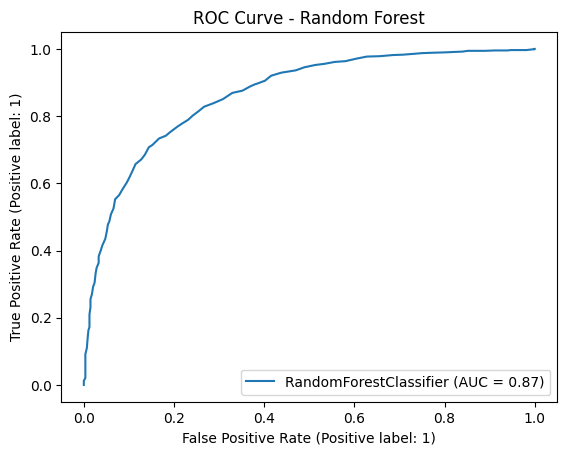

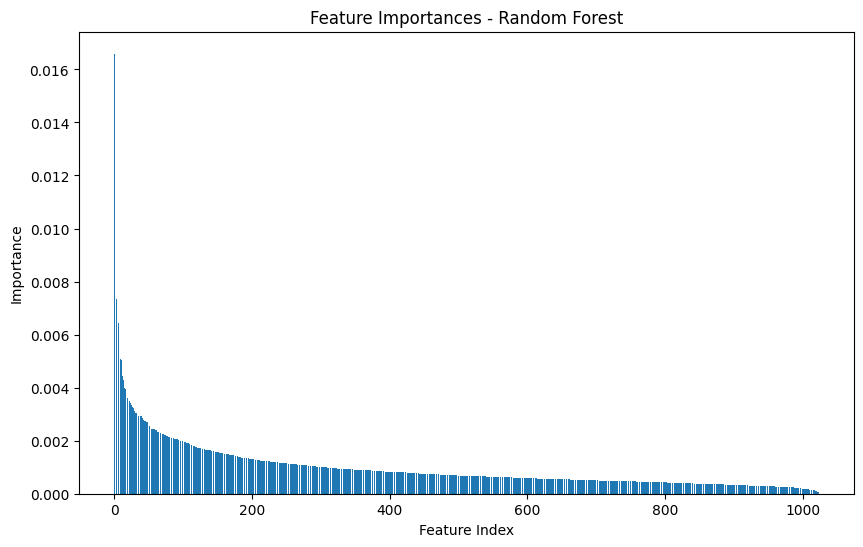

In [51]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

plot_model_performance(rf, X_test, y_test, "Random Forest")

# Importancia de features Random Forest
importances_rf = rf.feature_importances_
indices_rf = importances_rf.argsort()[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances_rf)), importances_rf[indices_rf], align='center')
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


### XGBoost: funcionamiento y características

**XGBoost** (Extreme Gradient Boosting) es un algoritmo de ensamble basado en **boosting de árboles de decisión**:

1. **Boosting de árboles**  
   - Construye árboles secuencialesmente, donde **cada nuevo árbol intenta corregir los errores del anterior**.  
   - Esto permite que el modelo aprenda patrones complejos y reduzca el sesgo.

2. **Predicción acumulativa**  
   - Cada árbol aporta una predicción que se suma a las predicciones anteriores.  
   - La salida final es la combinación ponderada de todos los árboles.

3. **Hiperparámetros principales**  
   - `n_estimators`: número total de árboles.  
   - `max_depth`: profundidad máxima de cada árbol.  
   - `learning_rate` (eta): cuánto contribuye cada árbol a la predicción final.  
   - `subsample`: fracción de muestras usadas para construir cada árbol (reduce sobreajuste).  
   - `colsample_bytree`: fracción de features consideradas para cada árbol.  
   - `gamma`: penalización mínima de reducción de pérdida para realizar una partición adicional.  
   - `min_child_weight`: suma mínima de pesos de instancias en un nodo hoja (controla sobreajuste).  
   - `reg_alpha` y `reg_lambda`: regularización L1 y L2 sobre los pesos de los árboles.

4. **Interpretación y uso**  
   - XGBoost es muy potente en datasets **con muchas features y relaciones no lineales**, como fingerprints químicas.  
   - Permite controlar sobreajuste mediante parámetros de regularización y muestreo.


c:\Users\Merce\miniconda3\envs\curso_quimioinformatica_ai\lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.77      0.77      0.77       881
           1       0.77      0.77      0.77       878

    accuracy                           0.77      1759
   macro avg       0.77      0.77      0.77      1759
weighted avg       0.77      0.77      0.77      1759



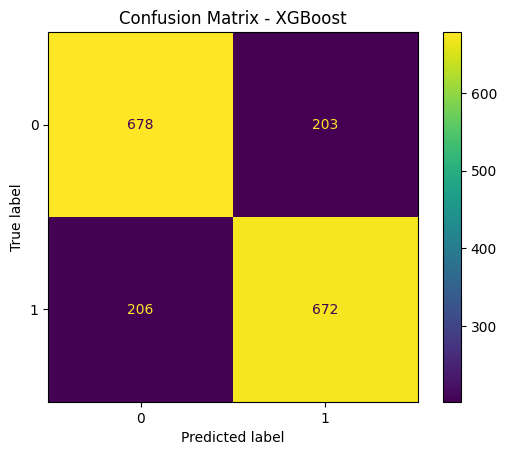

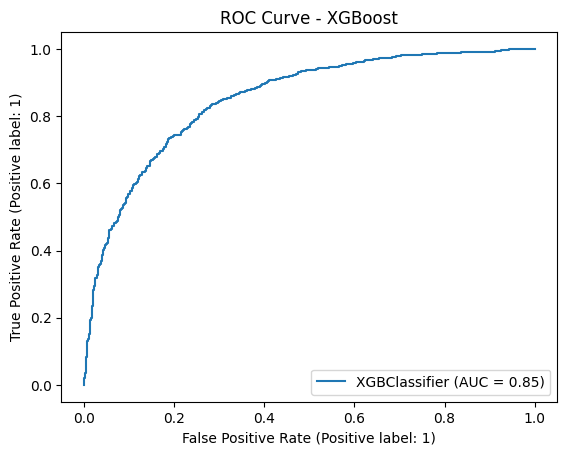

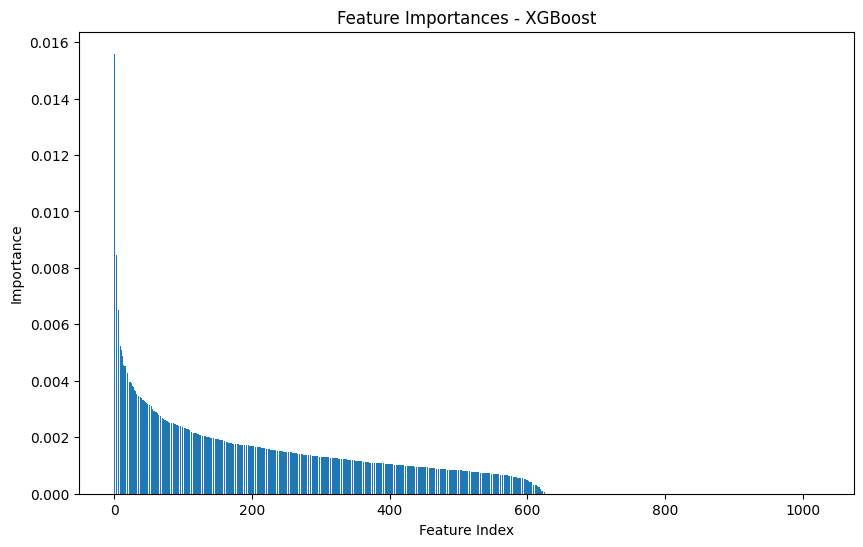

In [52]:
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

plot_model_performance(xgb_model, X_test, y_test, "XGBoost")

# Importancia de features XGBoost
importances_xgb = xgb_model.feature_importances_
indices_xgb = importances_xgb.argsort()[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances - XGBoost")
plt.bar(range(len(importances_xgb)), importances_xgb[indices_xgb], align='center')
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

### SVM (Support Vector Machine): funcionamiento y características

**Support Vector Machine (SVM)** es un algoritmo de clasificación que encuentra el **hiperplano que mejor separa las clases** en el espacio de features:

1. **Separación de clases**  
   - SVM busca maximizar el **margen** entre las clases, es decir, la distancia entre el hiperplano y los puntos más cercanos de cada clase (support vectors).  
   - Es especialmente útil cuando las clases no se superponen demasiado y el espacio de features es de alta dimensión.

2. **Kernel trick**  
   - Permite transformar los datos a un espacio de mayor dimensión donde puedan ser linealmente separables.  
   - Kernels comunes: `linear`, `rbf` (radial basis function), `poly` (polinomial).

3. **Hiperparámetros principales**  
   - `C`: controla la penalización por errores de clasificación. Valores grandes buscan **margen más estricto**, valores pequeños permiten más errores.  
   - `kernel`: tipo de función de kernel (`linear`, `rbf`, `poly`, `sigmoid`).  
   - `gamma`: define la influencia de un solo punto de entrenamiento en kernels como `rbf` o `poly`.  
   - `degree`: grado del polinomio (solo para kernel `poly`).  
   - `coef0`: término independiente en kernels `poly` o `sigmoid`.

4. **Interpretación y uso**  
   - SVM es muy efectivo en datasets con **muchas features**, como fingerprints químicas, donde las clases son separables en espacios de alta dimensión.  
   - Su principal ventaja es encontrar fronteras de decisión muy precisas, pero puede ser sensible a la elección de hiperparámetros y al tamaño del dataset.


              precision    recall  f1-score   support

           0       0.74      0.73      0.74       881
           1       0.73      0.74      0.74       878

    accuracy                           0.74      1759
   macro avg       0.74      0.74      0.74      1759
weighted avg       0.74      0.74      0.74      1759



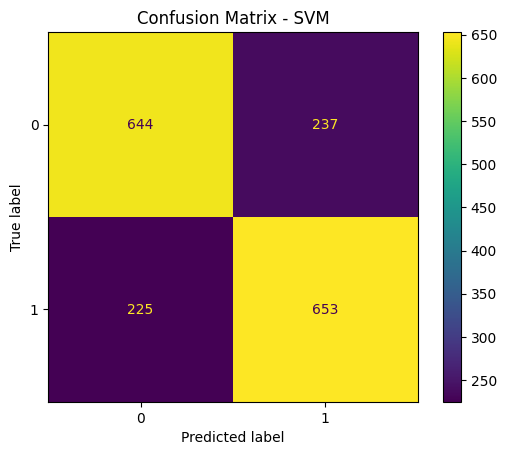

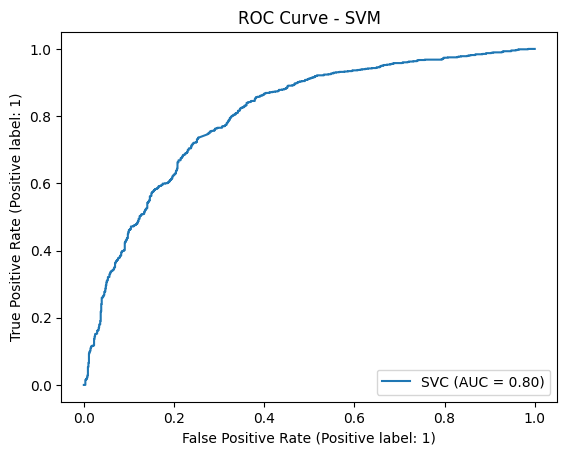

In [53]:
# SVM (con kernel lineal)
svm = SVC(kernel='linear', probability=True, random_state=42) #Este paso demora unos minutos! Tener paciencia!
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

plot_model_performance(svm, X_test, y_test, "SVM")

# Nota: SVM no tiene importancia de features directa.

# Trabajo en grupo
Ahora vamos a dividirnos en grupos y comprar las diferentes features con los diferentes modelos:

| #  | Fingerprint                  | Dataset    | Modelo        |
| -- | ---------------------------- | ---------- | ------------- |
| 1  | fp_morgan_array              | Balanceado | SVM           |
| 2  | fp_morgan_array              | Balanceado | Random Forest |
| 3  | fp_morgan_array              | Balanceado | XGBoost       |
| 4  | fp_morgan_array              | Completo   | SVM           |
| 5  | fp_morgan_array              | Completo   | Random Forest |
| 6  | fp_morgan_array              | Completo   | XGBoost       |
| 7  | fp_rdkit_array               | Balanceado | SVM           |
| 8  | fp_rdkit_array               | Balanceado | Random Forest |
| 9  | fp_rdkit_array               | Balanceado | XGBoost       |
| 10 | fp_rdkit_array               | Completo   | SVM           |
| 11 | fp_rdkit_array               | Completo   | Random Forest |
| 12 | fp_rdkit_array               | Completo   | XGBoost       |
| 13 | fp_maccs_array               | Balanceado | SVM           |
| 14 | fp_maccs_array               | Balanceado | Random Forest |
| 15 | fp_maccs_array               | Balanceado | XGBoost       |
| 16 | fp_maccs_array               | Completo   | SVM           |
| 17 | fp_maccs_array               | Completo   | Random Forest |
| 18 | fp_maccs_array               | Completo   | XGBoost       |
| 19 | fp_topological_torsion_array | Balanceado | SVM           |
| 20 | fp_topological_torsion_array | Balanceado | Random Forest |
| 21 | fp_topological_torsion_array | Balanceado | XGBoost       |
| 22 | fp_topological_torsion_array | Completo   | SVM           |
| 23 | fp_topological_torsion_array | Completo   | Random Forest |
| 24 | fp_topological_torsion_array | Completo   | XGBoost       |
| 25 | fp_atom_pair_array           | Balanceado | SVM           |
| 26 | fp_atom_pair_array           | Balanceado | Random Forest |
| 27 | fp_atom_pair_array           | Balanceado | XGBoost       |
| 28 | fp_atom_pair_array           | Completo   | SVM           |
| 29 | fp_atom_pair_array           | Completo   | Random Forest |
| 30 | fp_atom_pair_array           | Completo   | XGBoost       |

Incorporar los resultados a la [diapositiva](https://docs.google.com/presentation/d/1CCIcWUqV1pHKC2IPCLeP35USmgV1jcws92VtsUkTXEY/edit?usp=sharing) y completar la tabla final para comparar los resultaods obtenidos

# Consideraciones Generales y Cómo Colaborar

## Aspectos clave a tener en cuenta durante el desarrollo

- **Desbalance de datos:**  
  En problemas de clasificación de actividad biológica, es común que haya muchos más compuestos inactivos que activos (o viceversa). Este desbalance puede afectar negativamente el desempeño del modelo y provocar sesgos.  
  **Estrategias:** usar técnicas de balanceo como oversampling (SMOTE), undersampling, o ajustar métricas y umbrales.

- **Similitud intra e inter grupos:**  
  Evaluar la similitud química dentro del grupo de activos y dentro del de inactivos, así como entre ambos grupos, es importante para entender la diversidad y la dificultad del problema.  
  Esto ayuda a definir si el modelo podrá generalizar o si existen subgrupos muy distintos.

- **Definir un baseline:**  
  Es fundamental establecer un modelo o método base sencillo (baseline) para comparar el desempeño de modelos más complejos.  
  Ejemplo: un modelo que siempre predice la clase mayoritaria o usa una métrica simple para referencia.

## Cómo ayudar y colaborar en el proyecto

- **Reportar issues y bugs:**  
  Si encontrás errores o comportamientos inesperados, abrir un issue en GitHub con detalles claros.

- **Contribuir con código:**  
  Crear ramas feature para nuevas funcionalidades o mejoras, y hacer Pull Requests (PR) para revisión.

- **Documentar cambios:**  
  Mantener actualizado el README, comentarios en código y documentación general.

- **Compartir ideas y feedback:**  
  Discutir mejoras, nuevas funcionalidades o problemas en reuniones o a través de los canales designados.




# Retos y Problemas Comunes en Modelado de IA para Quimioinformática

Además de los puntos básicos, estos son algunos desafíos específicos que suelen presentarse al trabajar con datos químicos y biológicos para modelado con IA:

- **Calidad y ruido en los datos:**  
  Resultados experimentales pueden contener errores, inconsistencias o datos contradictorios, afectando la calidad del modelo.

- **Representación molecular incompleta o insuficiente:**  
  No siempre las representaciones estándar capturan toda la complejidad química necesaria para predecir actividad o propiedades.

- **Sobrerrepresentación de ciertas clases químicas:**  
  Algunas familias moleculares pueden estar sobrerrepresentadas, lo que puede sesgar el modelo hacia ellas.

- **Overfitting por poca diversidad química:**  
  Si los datos son demasiado similares, el modelo aprende patrones poco generales y falla en predecir compuestos nuevos.

- **Transferibilidad y generalización:**  
  Modelos que funcionan bien en un conjunto de datos pueden no generalizar a otros targets, ensayos o condiciones.

- **Interpretabilidad limitada:**  
  Los modelos complejos pueden ser difíciles de interpretar, complicando la extracción de conocimiento químico.

- **Escasez de datos para targets poco estudiados:**  
  Muchos blancos biológicos tienen pocos datos disponibles, limitando el entrenamiento de modelos fiables.

- **Desbalance de clases:**  
  Como mencionamos, el desbalance entre activos e inactivos afecta la evaluación y entrenamiento.

- **Problemas en la integración de múltiples fuentes de datos:**  
  Fusionar datos de distintas bases o tipos de ensayos puede ser complejo por diferencias en formatos, condiciones y calidad.

